# Kézzel írott számjegyek felismerése

In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
%matplotlib inline
import struct
import gc
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

### MNIST adatbázis betöltése

In [2]:
# tanito bemenetek beolvasasa
f=open("mnist_database/train_60k_images.dat","rb")
signature,=struct.unpack(">I",f.read(4))
numimages,=struct.unpack(">I",f.read(4))
rows,=struct.unpack(">I",f.read(4))
cols,=struct.unpack(">I",f.read(4))
if (rows!=28) or (cols!=28) or (signature!=2051) or (numimages!=60000):
    print("Hiba!")
else:
    train_images=np.empty([60000,784],dtype="float32")
    for i in range(60000):
        train_images[i]=np.array(struct.unpack("784B",f.read(784)),dtype="float32")/255
f.close()

# tanito kimenetek beolvasasa
f=open("mnist_database/train_60k_labels.dat","rb")
fdata=f.read()
f.close()
signature,=struct.unpack(">I",fdata[0:4])
numlabels,=struct.unpack(">I",fdata[4:8])
if (signature!=2049) or (numlabels!=60000):
    print("Hiba!")
else:
    train_labels=np.zeros([60000,10])
    for i in range(60000):
        temp,=struct.unpack("B",fdata[8+i])
        train_labels[i][temp]=1
fdata=[]

# teszt bemenetek beolvasasa
f=open("mnist_database/test_10k_images.dat","rb")
signature,=struct.unpack(">I",f.read(4))
numimages,=struct.unpack(">I",f.read(4))
rows,=struct.unpack(">I",f.read(4))
cols,=struct.unpack(">I",f.read(4))
if (rows!=28) or (cols!=28) or (signature!=2051) or (numimages!=10000):
    print("Hiba!")
else:
    test_images=np.empty([10000,784],dtype="float32")
    for i in range(10000):
        test_images[i]=np.array(struct.unpack("784B",f.read(784)),dtype="float32")/255
f.close()

# teszt kimenetek beolvasasa
f=open("mnist_database/test_10k_labels.dat","rb")
fdata=f.read()
f.close()
signature,=struct.unpack(">I",fdata[0:4])
numlabels,=struct.unpack(">I",fdata[4:8])
if (signature!=2049) or (numlabels!=10000):
    print("Hiba!")
else:
    test_labels=np.zeros([10000,10])
    for i in range(10000):
        temp,=struct.unpack("B",fdata[8+i])
        test_labels[i][temp]=1
fdata=[]

gc.collect()
print("MNIST adatbazis betoltve.")

MNIST adatbazis betoltve.


### Osztályozás egyszerű regresszióval

In [3]:
# batch_size darab, veletlenszeruen valasztott elemet ad vissza a tanito adatokbol
def get_batch(batch_size):
    global train_images, train_labels
    perm=np.random.permutation(train_images.shape[0])
    perm=perm[:batch_size]
    return [train_images[perm,:],train_labels[perm,:]]

In [9]:
sess=tf.Session()
# bemenet es kimenet
x =tf.placeholder(tf.float32,shape=[None,train_images.shape[1]])
y_=tf.placeholder(tf.float32,shape=[None,train_labels.shape[1]])
# sulymatrix es biasvektor
W=tf.Variable(tf.zeros([train_images.shape[1],train_labels.shape[1]]))
b=tf.Variable(tf.zeros([train_labels.shape[1]]))
# inicializalas
sess.run(tf.initialize_all_variables())
# regresszio
y=tf.nn.softmax(tf.matmul(x,W)+b)
cross_entropy=tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y),reduction_indices=[1]))
train_step=tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
# tanitas: 1000 epoch, 50-es kotegek
for i in range(1000):
    batch=get_batch(50)
    train_step.run(session=sess,feed_dict={x: batch[0], y_: batch[1]})

In [10]:
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1),tf.argmax(y_,1)),tf.float32))
print("Accuracy:\t%g"%accuracy.eval(session=sess,feed_dict={x: test_images, y_: test_labels}))
y_pred=np.argmax(sess.run(y,feed_dict={x:test_images,y_:test_labels}),1)
y_true=np.argmax(test_labels,1)
print("Precision:\t%g"%precision_score(y_true,y_pred,average="macro"))
print("Recall score:\t%g"%recall_score(y_true,y_pred,average="macro"))
print("F1 score:\t%g"%f1_score(y_true,y_pred,average="macro"))
print("Konfuzios matrix:")
print(confusion_matrix(y_true,y_pred))

Accuracy:	0.914
Precision:	0.914221
Recall score:	0.912778
F1 score:	0.912693
Konfuzios matrix:
[[ 959    0    2    2    0    4    8    2    3    0]
 [   0 1108    2    2    0    1    4    2   16    0]
 [  13    6  907   15   13    3   16   17   36    6]
 [   4    1   16  922    0   20    2   16   26    3]
 [   1    6    1    4  900    0   16    6   18   30]
 [  11    3    2   41    8  752   19   13   38    5]
 [  13    3    5    1    6   10  913    3    4    0]
 [   2    8   22    8    5    0    0  962    4   17]
 [   9    7    6   24    9   16   12   13  876    2]
 [  12    6    1   13   53    9    1   58   15  841]]


### Paraméterek fájlba írása

In [11]:
W=W.eval(sess)
b=b.eval(sess)

np.save("W.npy",W)
np.save("b.npy",b)

In [12]:
f=open("regr_parameters.h","wt")
f.write("#ifndef _REGR_PARAMETERS_H_\n")
f.write("#define _REGR_PARAMETERS_H_\n\n")

f.write("const float W[%d][%d]={\n"%(W.shape[0],W.shape[1]))
for r in range(W.shape[0]):
    f.write("{")
    for c in range(W.shape[1]):
        f.write("%.8ff"%W[r,c])
        if c<W.shape[1]-1: f.write(", ")
    f.write("}")
    if r<W.shape[0]-1: f.write(",")
    f.write("\n")
f.write("};\n\n")

f.write("const float b[%d]={"%b.shape[0])
for i in range(b.shape[0]):
    f.write("%.8ff"%b[i])
    if i<b.shape[0]-1: f.write(", ")
f.write("};\n\n")

f.write("#endif")
f.close()

npar=W.size+b.size
print("Osszesen %d parameter (%d kB)."%(npar,npar*4/1024))

Osszesen 7850 parameter (30 kB).


### Osztályozás konvolúciós hálóval

In [13]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape=shape,stddev=0.1,name="weights"))
def bias_variable(shape):
    return tf.Variable(tf.constant(value=0.1,shape=shape))
def conv2d(x,W,name):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME",name=name)
def maxpool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

# konvolucios reteg: 1 28x28-as bemenet, 32 5x5-os szuro, 2x2-es zero padding --> 32 28x28-as kimenet
W_conv1=weight_variable([5,5,1,32])
b_conv1=bias_variable([32])
h_conv1=tf.nn.relu(conv2d(tf.reshape(x,[-1,28,28,1]),W_conv1,"h_conv1")+b_conv1)
# maxpool reteg: 32 db 28x28 --> 32 db 14x14
h_pool1=maxpool_2x2(h_conv1)
# konvolucios reteg: 32 28x28-as bemenet, 64 5x5-os szuro, 2x2-es zero padding --> 64 28x28-as kimenet
W_conv2=weight_variable([5,5,32,64])
b_conv2=bias_variable([64])
h_conv2=tf.nn.relu(conv2d(h_pool1,W_conv2,"h_conv2")+b_conv2)
# maxpool reteg: 64 db 14x14 --> 64 db 7x7
h_pool2=maxpool_2x2(h_conv2)
# a maxpool reteget kilapitjuk, es raadjuk egy teljesen osszekotott retegre: 3136 --> 2014 (ReLU)
W_fc1=weight_variable([7*7*64,1024])
b_fc1=bias_variable([1024])
h_fc1=tf.nn.relu(tf.matmul(tf.reshape(h_pool2,[-1,7*7*64]),W_fc1)+b_fc1)
# dropout
keep_prob=tf.placeholder(tf.float32)
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)
# kimeneti reteg: 1024 --> 10 (softmax)
W_fc2=weight_variable([1024,10])
b_fc2=bias_variable([10])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2)+b_fc2)

In [14]:
cross_entropy=tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_conv),reduction_indices=[1]))
train_step=tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction=tf.equal(tf.argmax(y_conv,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch=get_batch(50)
    if (i+1)%100==0:
        print("Step %d, accuracy is %g."%(i+1,
              accuracy.eval(session=sess,feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})))
    train_step.run(session=sess,feed_dict={x:batch[0],y_:batch[1],keep_prob:0.5})

Step 100, accuracy is 0.86.
Step 200, accuracy is 0.88.
Step 300, accuracy is 0.98.
Step 400, accuracy is 0.9.
Step 500, accuracy is 0.98.
Step 600, accuracy is 0.96.
Step 700, accuracy is 0.96.
Step 800, accuracy is 0.96.
Step 900, accuracy is 0.98.
Step 1000, accuracy is 0.88.


In [15]:
y_pred=np.empty(test_images.shape[0])
for i in range(test_images.shape[0]): # egyszerre is ra lehetne adni, de ahhoz sok memoria kell
    out=sess.run(y_conv,feed_dict={x:  np.atleast_2d(test_images[i]),
                                   y_: np.atleast_2d(test_labels[i]), keep_prob: 1.0})
    y_pred[i]=np.argmax(out,1)
y_true=np.argmax(test_labels,1)
print("Precision:\t%g"%precision_score(y_true,y_pred,average="macro"))
print("Recall score:\t%g"%recall_score(y_true,y_pred,average="macro"))
print("F1 score:\t%g"%f1_score(y_true,y_pred,average="macro"))
print("Konfuzios matrix:")
print(confusion_matrix(y_true,y_pred))

Precision:	0.963251
Recall score:	0.962739
F1 score:	0.962753
Konfuzios matrix:
[[ 967    0    3    0    0    1    6    1    2    0]
 [   0 1118    4    0    1    1    5    0    6    0]
 [   3    0 1008    4    2    0    3    4    8    0]
 [   0    0   22  955    0   12    0    4   12    5]
 [   1    0    3    0  953    0    9    2    3   11]
 [   5    1    2    4    0  853   12    1   11    3]
 [   8    2    2    0    2    3  937    0    4    0]
 [   2    4   38    4    6    1    0  946    2   25]
 [   8    0   10    6    5    0    4    4  931    6]
 [   9    6    2    9   12    0    1    1    8  961]]


### A konvolúciós rétegek kimenetei

In [16]:
def showConvLayerOutputs(layer,inputdata):
    units=layer.eval(session=sess,feed_dict={x:np.reshape(inputdata,[1,784],order='F'),keep_prob:1.0})
    no_filters=units.shape[3]
    plt.figure(figsize=(32,35))
    for i in range(0,no_filters):
        plt.subplot(math.ceil(no_filters/6.0),6,i+1)
        plt.title("Filter "+str(i))
        plt.imshow(units[0,:,:,i],interpolation="none",cmap="gray")
        plt.axis("off")

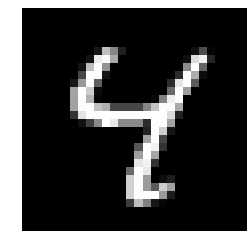

In [19]:
testInput=test_images[6]
plt.imshow(np.reshape(testInput,[28,28]),interpolation="nearest",cmap="gray")
plt.axis("off");

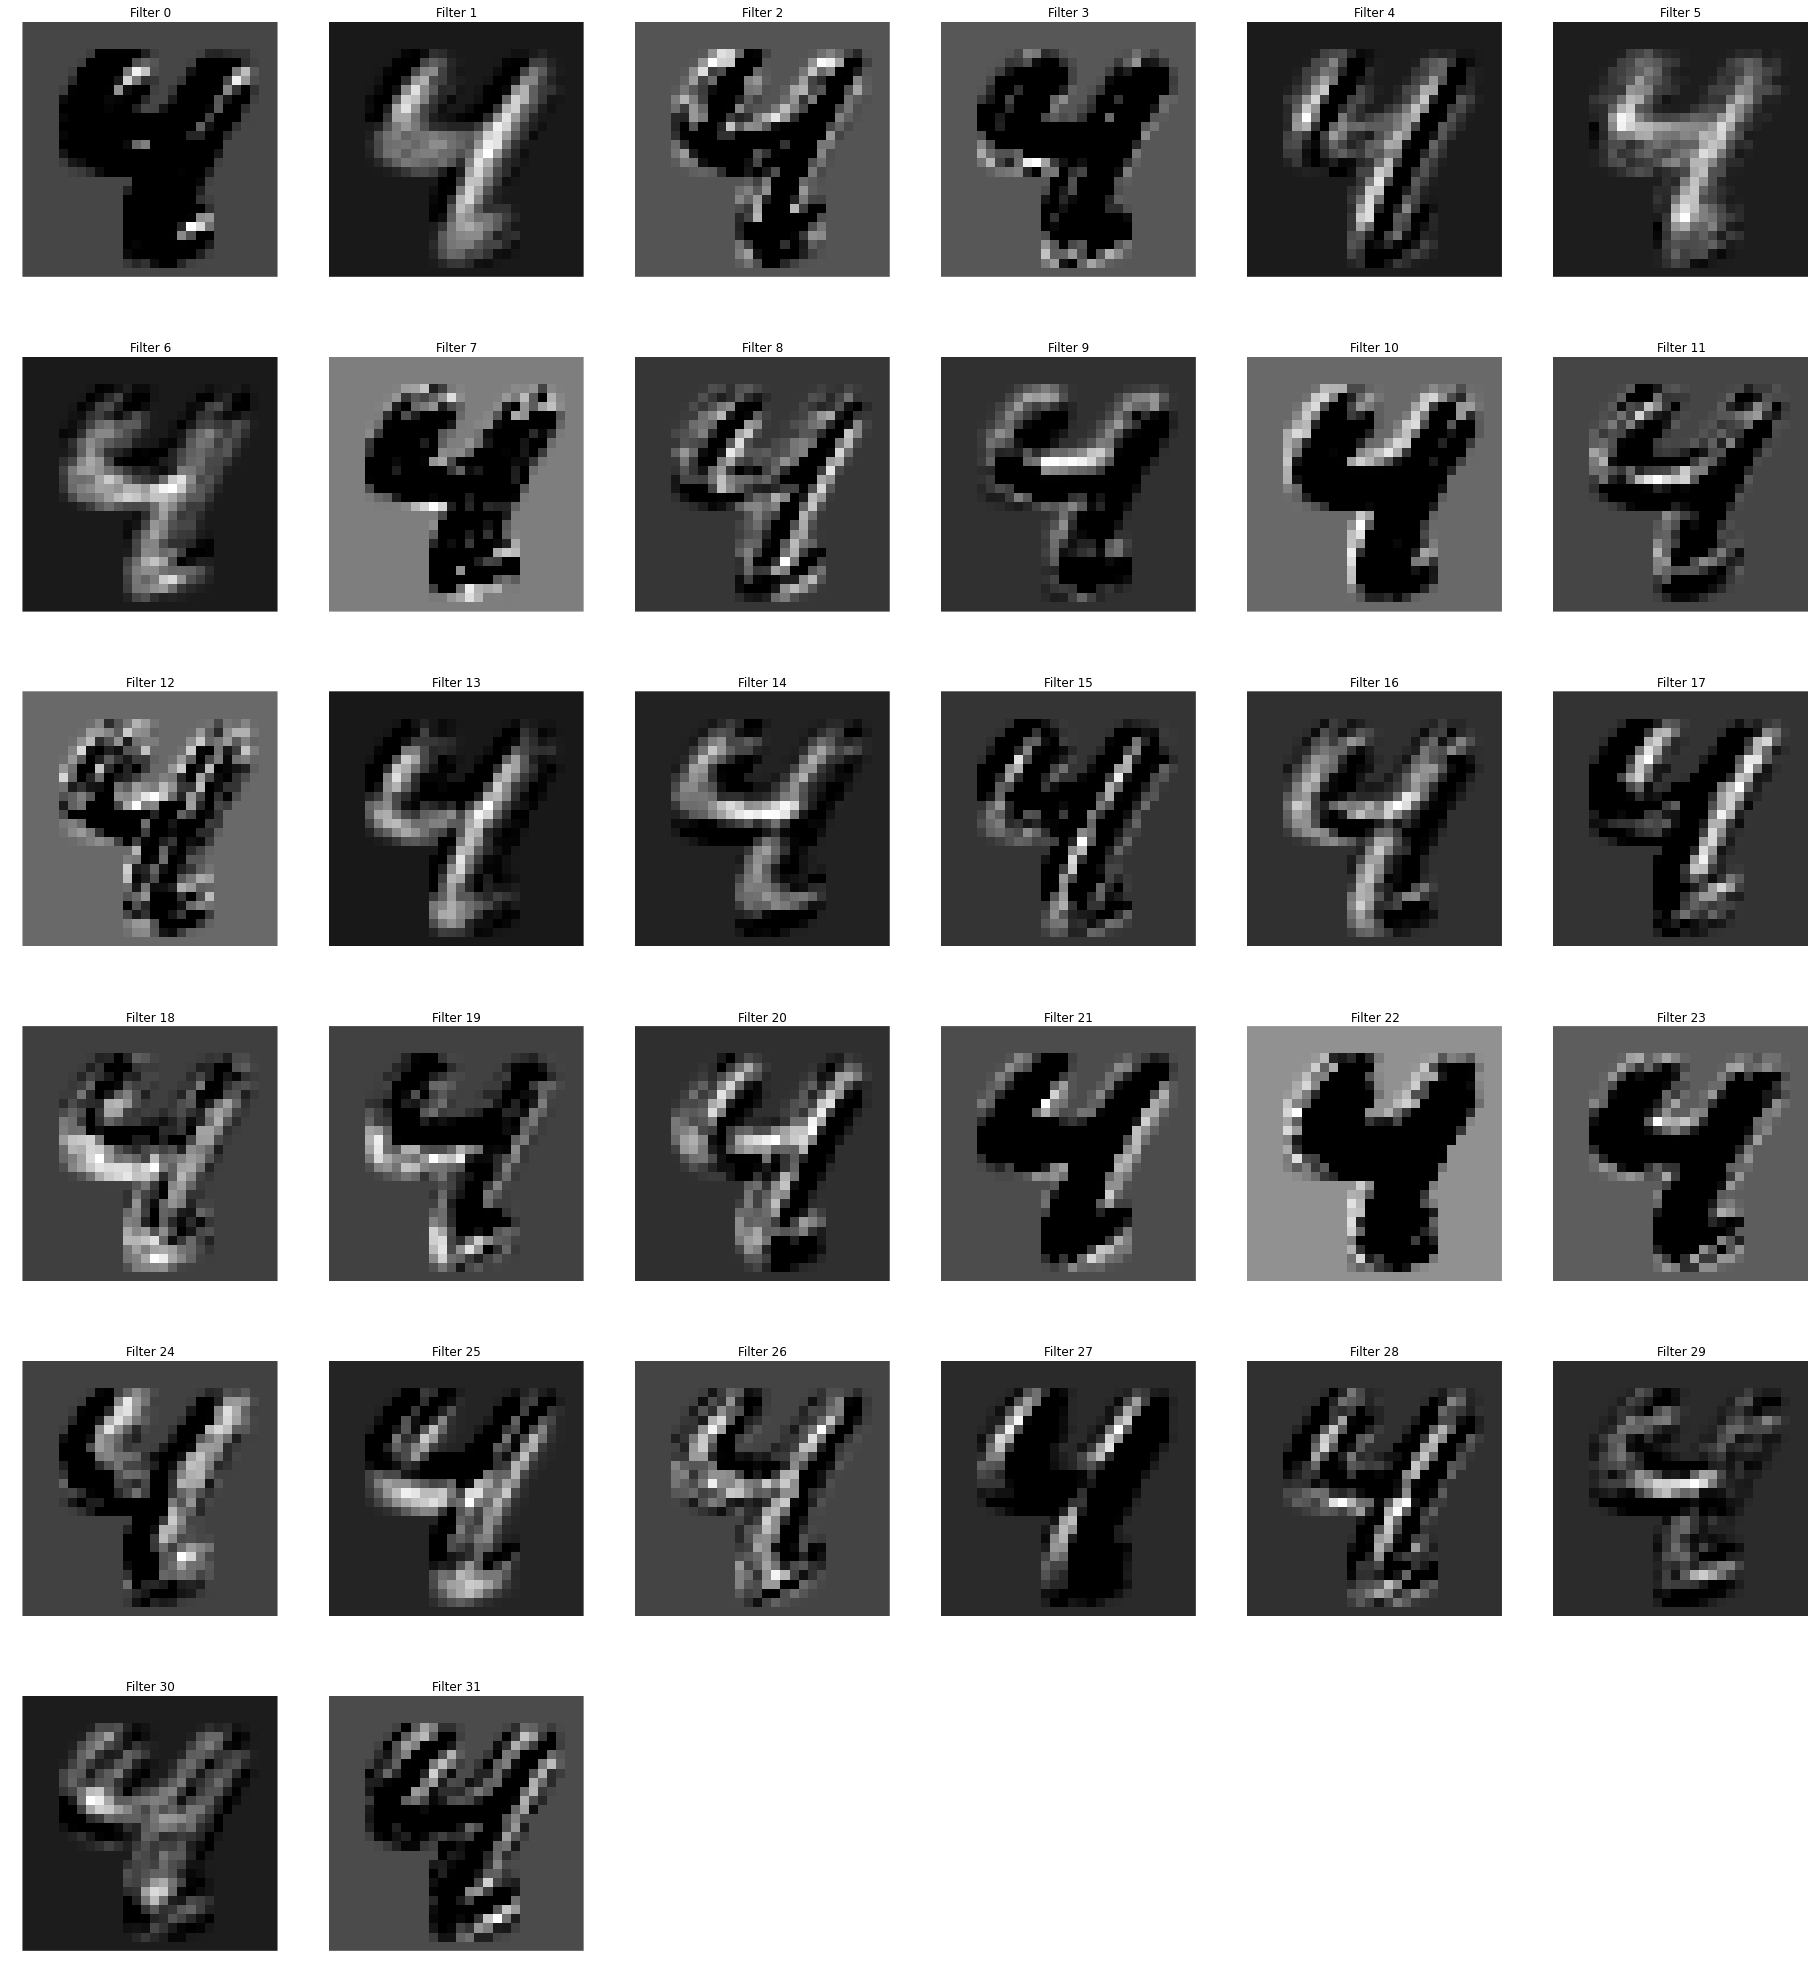

In [20]:
showConvLayerOutputs(h_conv1,testInput)

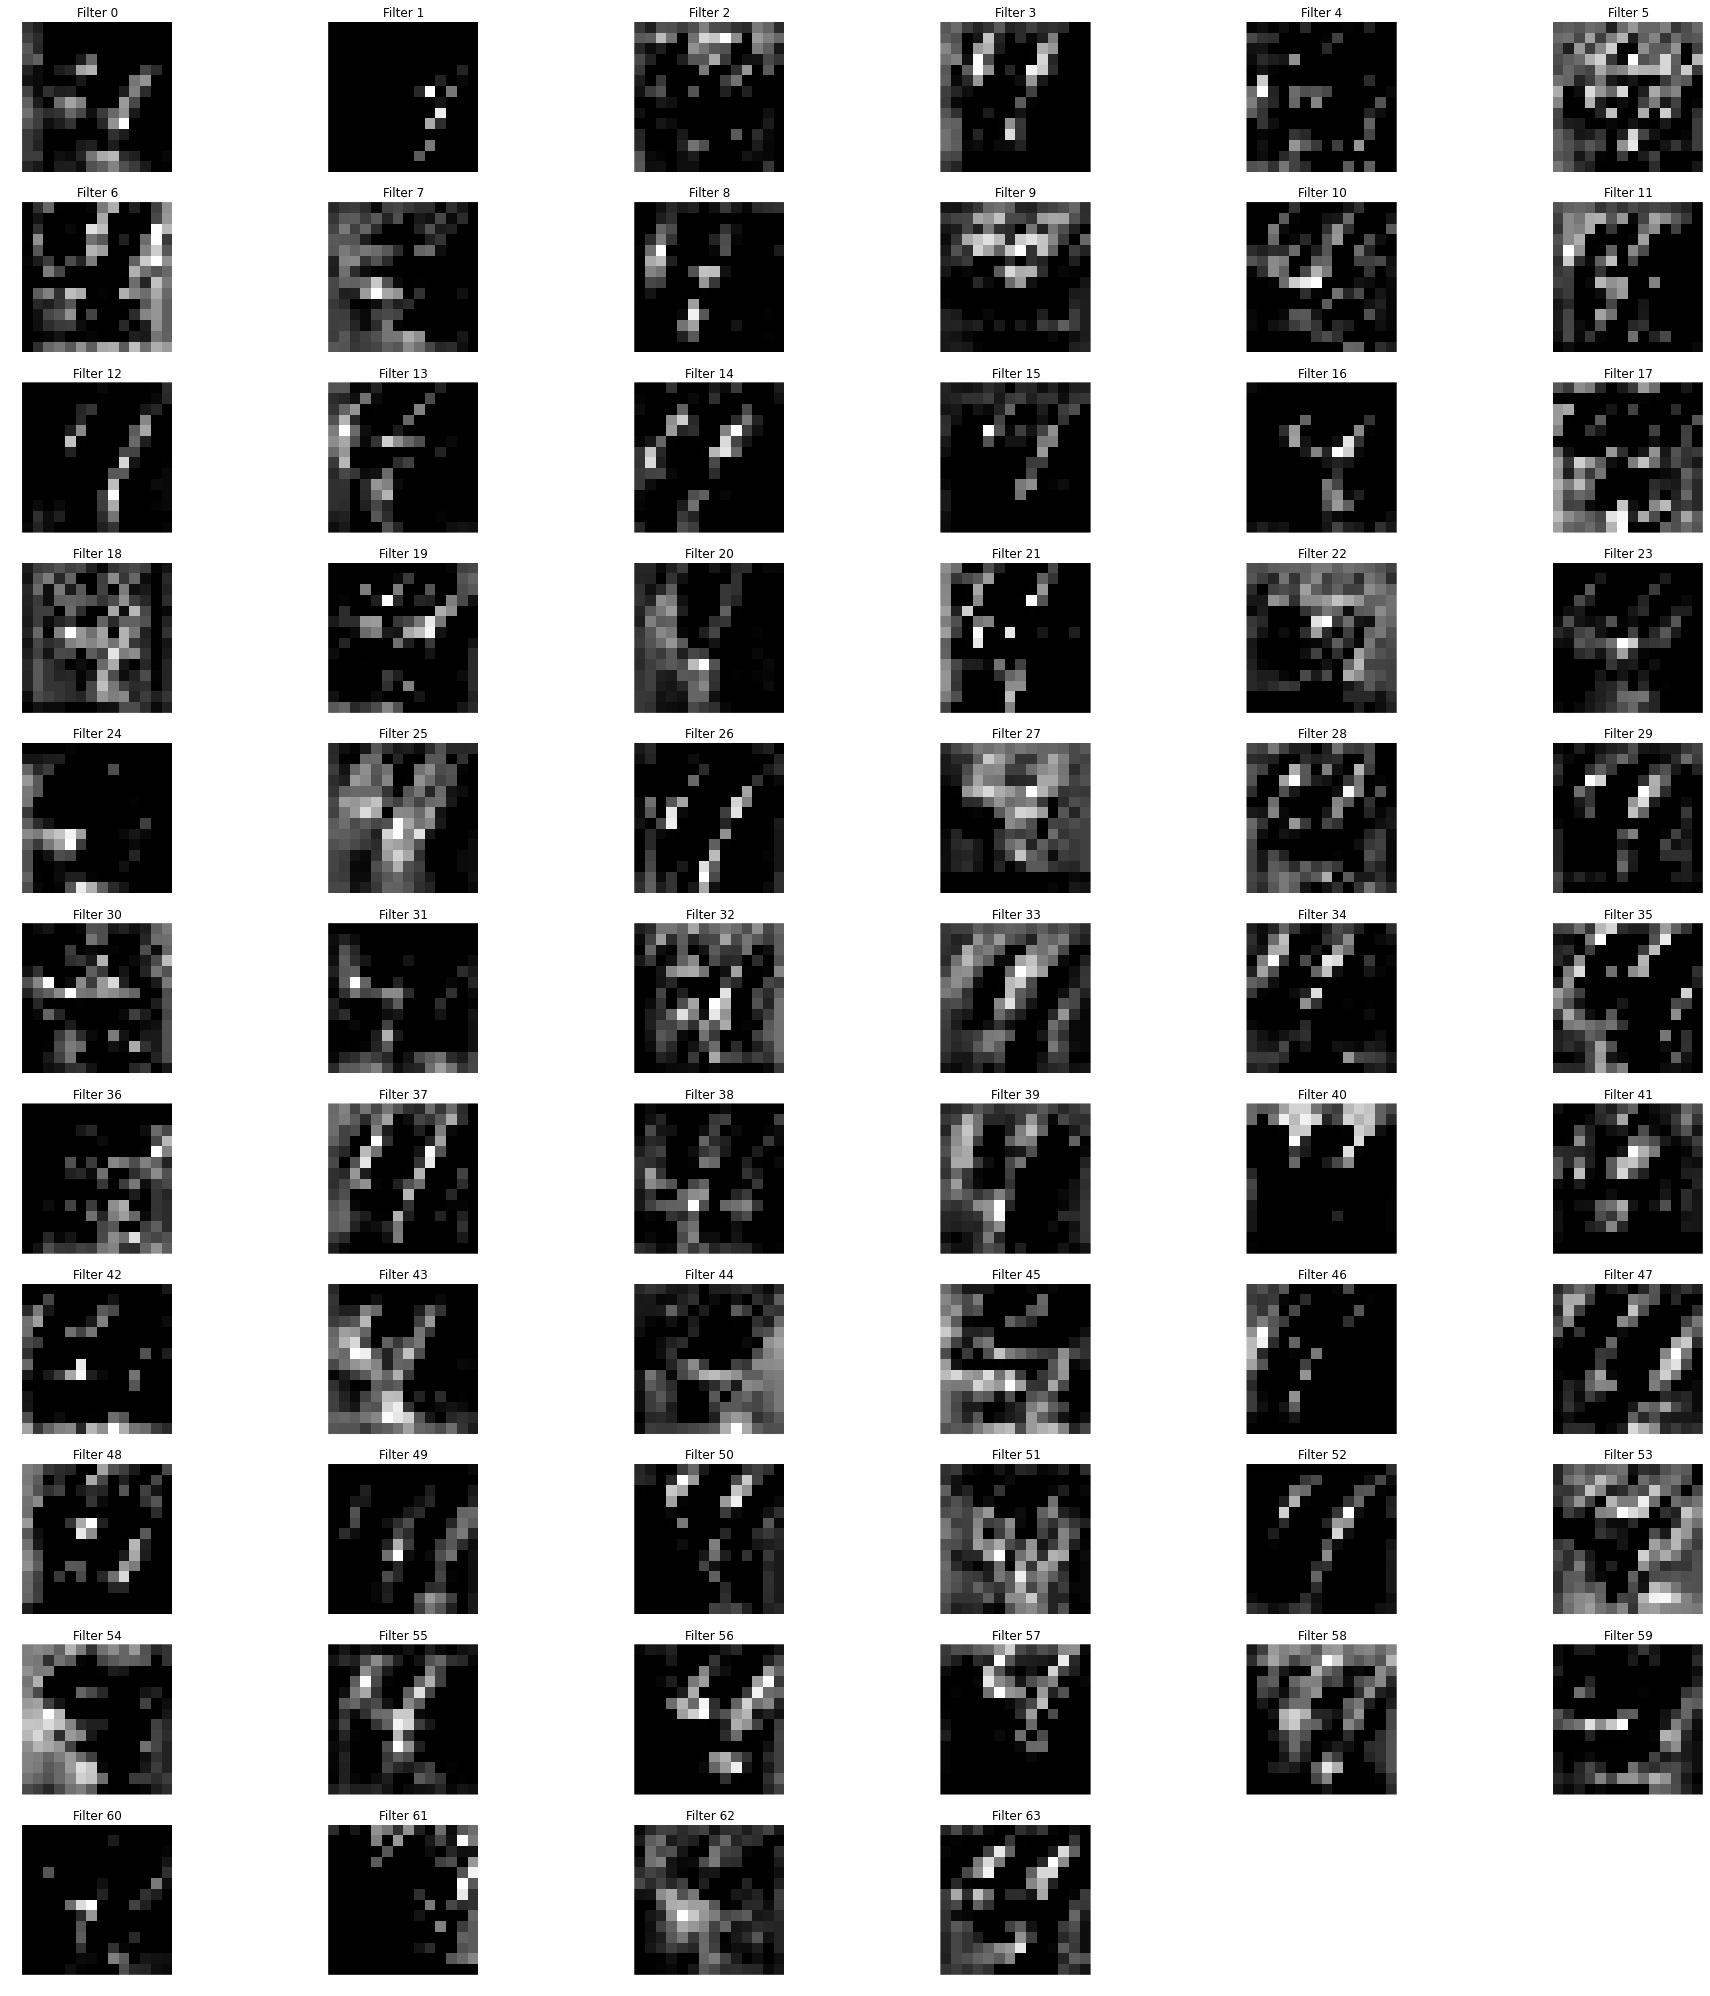

In [21]:
showConvLayerOutputs(h_conv2,testInput)

### Paraméterek fájlba írása

In [22]:
W_conv1=W_conv1.eval(sess)
b_conv1=b_conv1.eval(sess)
W_conv2=W_conv2.eval(sess)
b_conv2=b_conv2.eval(sess)
W_fc1=W_fc1.eval(sess)
b_fc1=b_fc1.eval(sess)
W_fc2=W_fc2.eval(sess)
b_fc2=b_fc2.eval(sess)

np.save("W_conv1.npy",W_conv1)
np.save("b_conv1.npy",b_conv1)
np.save("W_conv2.npy",W_conv2)
np.save("b_conv2.npy",b_conv2)
np.save("W_fc1.npy",W_fc1)
np.save("b_fc1.npy",b_fc1)
np.save("W_fc2.npy",W_fc2)
np.save("b_fc2.npy",b_fc2)

In [23]:
f=open("cnn_parameters.h","wt")
f.write("#ifndef _CNN_PARAMETERS_H_\n")
f.write("#define _CNN_PARAMETERS_H_\n\n")

f.write("const float W_conv1[%d][%d][%d]={\n"%(W_conv1.shape[0],W_conv1.shape[1],W_conv1.shape[3]))
for i in range(W_conv1.shape[3]):
    f.write("{\n")
    for r in range(W_conv1.shape[0]):
        f.write("{")
        for c in range(W_conv1.shape[1]):
            f.write("%.8ff"%W_conv1[r,c,0,i])
            if c<W_conv1.shape[1]-1: f.write(", ")
        f.write("}")
        if r<W_conv1.shape[0]-1: f.write(",")
        f.write("\n")
    f.write("}")
    if i<W_conv1.shape[3]-1: f.write(",")
    f.write("\n")
f.write("};\n\n")

f.write("const float b_conv1[%d]={"%b_conv1.shape[0])
for i in range(b_conv1.shape[0]):
    f.write("%.8ff"%b_conv1[i])
    if i<b_conv1.shape[0]-1: f.write(", ")
f.write("};\n\n")

f.write("const float W_conv2[%d][%d][%d]={\n"%(W_conv2.shape[0],W_conv2.shape[1],W_conv2.shape[3]))
for i in range(W_conv2.shape[3]):
    f.write("{\n")
    for r in range(W_conv2.shape[0]):
        f.write("{")
        for c in range(W_conv2.shape[1]):
            f.write("%.8ff"%W_conv2[r,c,0,i])
            if c<W_conv2.shape[1]-1: f.write(", ")
        f.write("}")
        if r<W_conv2.shape[0]-1: f.write(",")
        f.write("\n")
    f.write("}")
    if i<W_conv2.shape[3]-1: f.write(",")
    f.write("\n")
f.write("};\n\n")

f.write("const float b_conv2[%d]={"%b_conv2.shape[0])
for i in range(b_conv2.shape[0]):
    f.write("%.8ff"%b_conv2[i])
    if i<b_conv2.shape[0]-1: f.write(", ")
f.write("};\n\n")

f.write("const float W_fc1[%d][%d]={\n"%(W_fc1.shape[0],W_fc1.shape[1]))
for r in range(W_fc1.shape[0]):
    f.write("{")
    for c in range(W_fc1.shape[1]):
        f.write("%.8ff"%W_fc1[r,c])
        if c<W_fc1.shape[1]-1: f.write(", ")
    f.write("}")
    if r<W_fc1.shape[0]-1: f.write(",")
    f.write("\n")
f.write("};\n\n")

f.write("const float b_fc1[%d]={"%b_fc1.shape[0])
for i in range(b_fc1.shape[0]):
    f.write("%.8ff"%b_fc1[i])
    if i<b_fc1.shape[0]-1: f.write(", ")
f.write("};\n\n")

f.write("const float W_fc2[%d][%d]={\n"%(W_fc2.shape[0],W_fc2.shape[1]))
for r in range(W_fc2.shape[0]):
    f.write("{")
    for c in range(W_fc2.shape[1]):
        f.write("%.8ff"%W_fc2[r,c])
        if c<W_fc2.shape[1]-1: f.write(", ")
    f.write("}")
    if r<W_fc2.shape[0]-1: f.write(",")
    f.write("\n")
f.write("};\n\n")

f.write("const float b_fc2[%d]={"%b_fc2.shape[0])
for i in range(b_fc2.shape[0]):
    f.write("%.8ff"%b_fc2[i])
    if i<b_fc2.shape[0]-1: f.write(", ")
f.write("};\n\n")

f.write("#endif\n")
f.close()

npar=W_conv1.size+b_conv1.size+W_conv2.size+b_conv2.size+W_fc1.size+b_fc1.size+W_fc2.size+b_fc2.size
print("Osszesen %d parameter (%d MB)."%(npar,npar*4/1024/1024))

Osszesen 3274634 parameter (12 MB).
